Starting cross-dataset DDoS detection experiment...
CROSS-DATASET DDoS DETECTION - WORKING VERSION

[1/4] Loading and sampling data...
Loading Edge-IIoTset (ensuring DDoS samples)...
Full dataset loaded: (2219201, 63)
DDoS samples available: 337,977
Normal samples available: 1,615,643

Sampled dataset: (200000, 64)
Class distribution: {0: 100000, 1: 100000}

Loading CICIoT2023 with balanced classes...
Full CICIoT2023 loaded: (5491971, 47)
DDoS/DoS samples available: 4,949,156
Normal samples available: 129,538

Sampled dataset: (50000, 48)
Class distribution: {0: 25000, 1: 25000}

[2/4] Extracting features...
Extracting features from Edge-IIoTset...
Extracted features: (200000, 43)
Extracting features from CICIoT2023...
Extracted features: (50000, 46)

Train features: (200000, 43), Classes: Counter({np.int64(0): 100000, np.int64(1): 100000})
Test features: (50000, 46), Classes: Counter({np.int64(0): 25000, np.int64(1): 25000})

[3/4] Aligning features...

Aligning features to 50 dimensi

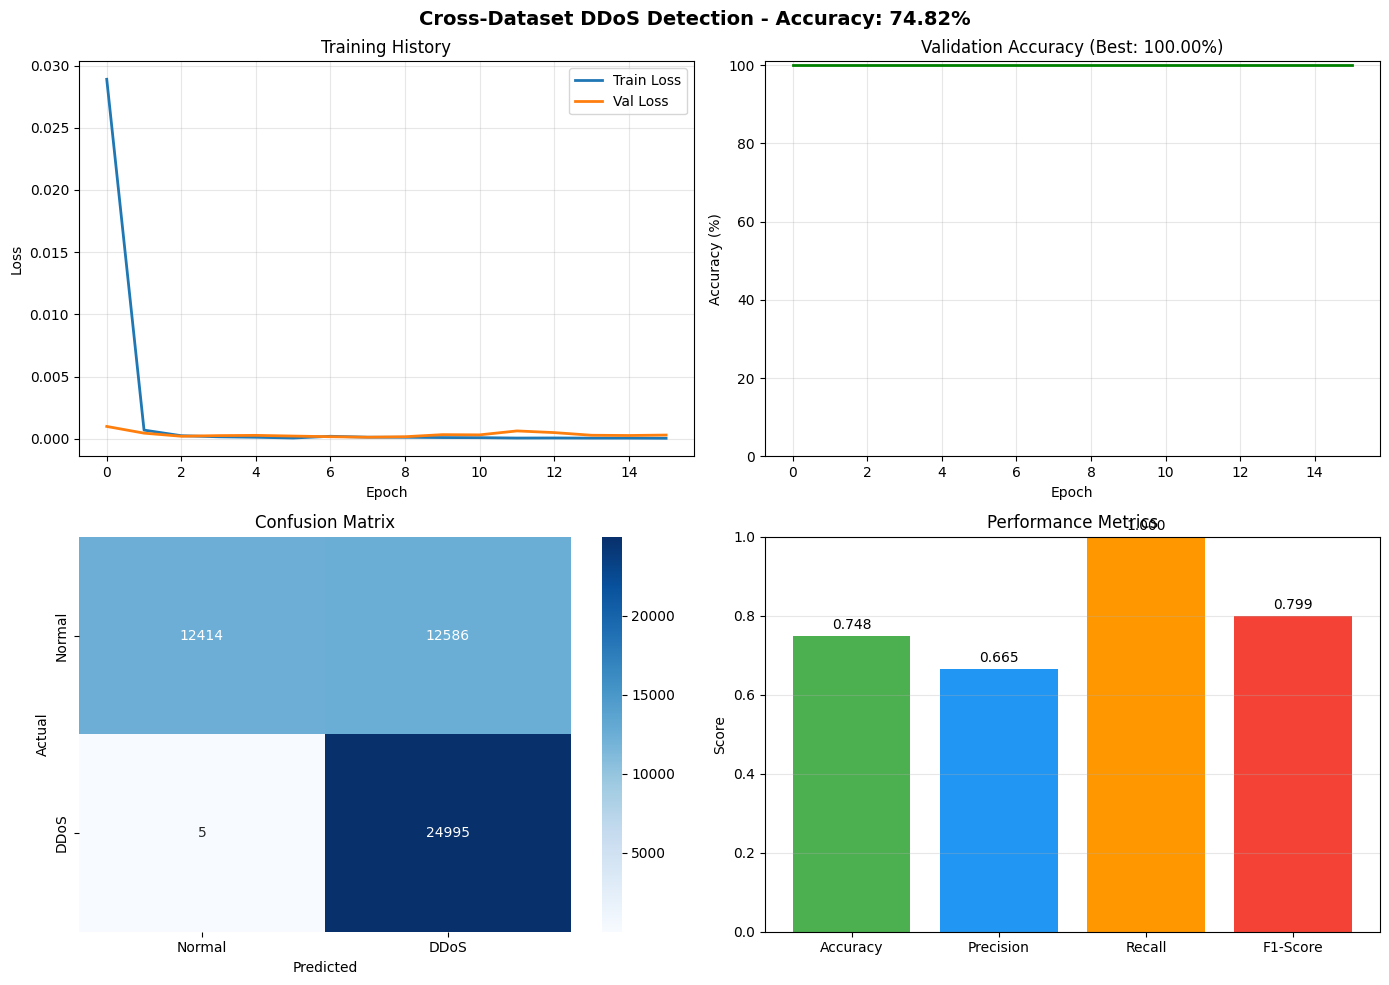


Results saved to 'results.txt'
Visualization saved to 'results.png'

📊 Results achieved. To improve:
  1. Increase sample sizes
  2. Try more complex model
  3. Use feature engineering

Final Accuracy: 74.82%

Total execution time: 2.42 minutes
Model saved: 'best_model.pth'


In [1]:
# ============ FIXED CODE WITH PROPER SAMPLING ============

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import gc
import time
from collections import Counter
import os

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

# ============ 1. PROPER DATA LOADING AND SAMPLING ============

class DataLoaderFixed:
    """Fixed data loader that ensures we get both classes"""
    
    @staticmethod
    def load_edgeiiot_with_ddos(sample_size=500000):
        """Load Edge-IIoTset ensuring we get DDoS samples"""
        print("Loading Edge-IIoTset (ensuring DDoS samples)...")
        
        # Load the dataset
        df = pd.read_csv(
            '/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv',
            low_memory=False
        )
        
        print(f"Full dataset loaded: {df.shape}")
        
        # Get DDoS samples first
        ddos_attacks = ['DDoS_TCP', 'DDoS_UDP', 'DDoS_HTTP', 'DDoS_ICMP']
        ddos_mask = df['Attack_type'].isin(ddos_attacks)
        ddos_df = df[ddos_mask].copy()
        
        # Get Normal samples
        normal_df = df[df['Attack_type'] == 'Normal'].copy()
        
        print(f"DDoS samples available: {len(ddos_df):,}")
        print(f"Normal samples available: {len(normal_df):,}")
        
        # Sample balanced dataset
        ddos_sample_size = min(sample_size // 2, len(ddos_df))
        normal_sample_size = min(sample_size // 2, len(normal_df))
        
        # If not enough DDoS, adjust
        if ddos_sample_size < sample_size // 4:
            print(f"Warning: Only {ddos_sample_size:,} DDoS samples available")
            # Use more normal samples
            normal_sample_size = min(sample_size - ddos_sample_size, len(normal_df))
        
        ddos_sampled = ddos_df.sample(n=ddos_sample_size, random_state=42)
        normal_sampled = normal_df.sample(n=normal_sample_size, random_state=42)
        
        # Combine
        df_sampled = pd.concat([ddos_sampled, normal_sampled])
        df_sampled = df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)
        
        # Create labels
        df_sampled['target'] = df_sampled['Attack_type'].apply(
            lambda x: 1 if x in ddos_attacks else 0
        )
        
        print(f"\nSampled dataset: {df_sampled.shape}")
        print(f"Class distribution: {df_sampled['target'].value_counts().to_dict()}")
        
        return df_sampled
    
    @staticmethod
    def load_ciciot_balanced(sample_size=100000):
        """Load CICIoT2023 with balanced classes"""
        print("\nLoading CICIoT2023 with balanced classes...")
        
        # Load the dataset
        df = pd.read_csv(
            '/kaggle/input/ciciot2023/CICIOT23/train/train.csv',
            low_memory=False
        )
        
        print(f"Full CICIoT2023 loaded: {df.shape}")
        
        # Get DDoS/DoS samples
        ddos_mask = df['label'].str.contains('DDoS|DoS', case=False, na=False)
        ddos_df = df[ddos_mask].copy()
        
        # Get Normal/Benign samples
        normal_df = df[df['label'] == 'BenignTraffic'].copy()
        
        print(f"DDoS/DoS samples available: {len(ddos_df):,}")
        print(f"Normal samples available: {len(normal_df):,}")
        
        # Sample balanced dataset
        ddos_sample_size = min(sample_size // 2, len(ddos_df))
        normal_sample_size = min(sample_size // 2, len(normal_df))
        
        # If not enough normal, use more DDoS
        if normal_sample_size < sample_size // 4:
            print(f"Warning: Only {normal_sample_size:,} normal samples available")
            ddos_sample_size = min(sample_size - normal_sample_size, len(ddos_df))
        
        ddos_sampled = ddos_df.sample(n=ddos_sample_size, random_state=42)
        normal_sampled = normal_df.sample(n=normal_sample_size, random_state=42)
        
        # Combine
        df_sampled = pd.concat([ddos_sampled, normal_sampled])
        df_sampled = df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)
        
        # Create labels
        df_sampled['target'] = df_sampled['label'].apply(
            lambda x: 1 if any(kw in str(x) for kw in ['DDoS', 'DoS']) else 0
        )
        
        print(f"\nSampled dataset: {df_sampled.shape}")
        print(f"Class distribution: {df_sampled['target'].value_counts().to_dict()}")
        
        return df_sampled

# ============ 2. SIMPLE FEATURE EXTRACTION ============

class SimpleFeatureExtractor:
    """Extract simple numeric features from both datasets"""
    
    @staticmethod
    def extract_features_edgeiiot(df):
        """Extract features from Edge-IIoTset"""
        print("Extracting features from Edge-IIoTset...")
        
        # Drop non-numeric columns and target
        non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()
        
        # Keep only numeric columns
        numeric_cols = [col for col in df.columns if col not in non_numeric_cols and col != 'target']
        
        # Fill missing values
        X = df[numeric_cols].fillna(0).values
        
        # Get labels
        y = df['target'].values
        
        print(f"Extracted features: {X.shape}")
        return X, y, numeric_cols
    
    @staticmethod
    def extract_features_ciciot(df):
        """Extract features from CICIoT2023"""
        print("Extracting features from CICIoT2023...")
        
        # Drop non-numeric columns and target
        non_numeric_cols = ['label']  # Only label is non-numeric
        
        # Keep only numeric columns
        numeric_cols = [col for col in df.columns if col not in non_numeric_cols and col != 'target']
        
        # Fill missing values
        X = df[numeric_cols].fillna(0).values
        
        # Get labels
        y = df['target'].values
        
        print(f"Extracted features: {X.shape}")
        return X, y, numeric_cols
    
    @staticmethod
    def align_features(X1, X2, target_dim=50):
        """Align features to same dimension"""
        print(f"\nAligning features to {target_dim} dimensions...")
        
        # Pad or truncate
        if X1.shape[1] < target_dim:
            pad_width = target_dim - X1.shape[1]
            X1 = np.pad(X1, ((0, 0), (0, pad_width)), mode='constant')
            print(f"Padded X1 from {X1.shape[1]-pad_width} to {target_dim}")
        elif X1.shape[1] > target_dim:
            X1 = X1[:, :target_dim]
            print(f"Truncated X1 to {target_dim}")
        
        if X2.shape[1] < target_dim:
            pad_width = target_dim - X2.shape[1]
            X2 = np.pad(X2, ((0, 0), (0, pad_width)), mode='constant')
            print(f"Padded X2 from {X2.shape[1]-pad_width} to {target_dim}")
        elif X2.shape[1] > target_dim:
            X2 = X2[:, :target_dim]
            print(f"Truncated X2 to {target_dim}")
        
        print(f"Final shapes: X1={X1.shape}, X2={X2.shape}")
        return X1, X2

# ============ 3. SIMPLE BUT EFFECTIVE MODEL ============

class SimpleDDoSModel(nn.Module):
    """Simple model that works"""
    
    def __init__(self, input_dim, num_classes=2):
        super(SimpleDDoSModel, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            
            nn.Linear(32, num_classes)
        )
    
    def forward(self, x):
        return self.network(x)

# ============ 4. TRAINING LOOP ============

class Trainer:
    """Simple trainer"""
    
    def __init__(self, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
    
    def train(self, model, train_loader, val_loader, epochs=100, lr=0.001):
        """Train model"""
        model = model.to(self.device)
        
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)
        criterion = nn.CrossEntropyLoss()
        
        train_losses = []
        val_losses = []
        val_accuracies = []
        
        best_acc = 0.0
        patience_counter = 0
        patience = 15
        
        for epoch in range(epochs):
            # Training
            model.train()
            train_loss = 0.0
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
                
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
            
            # Validation
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
                    outputs = model(batch_x)
                    loss = criterion(outputs, batch_y)
                    
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += batch_y.size(0)
                    correct += predicted.eq(batch_y).sum().item()
            
            # Calculate metrics
            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            val_acc = 100. * correct / total
            
            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
            val_accuracies.append(val_acc)
            
            # Learning rate scheduling
            scheduler.step(val_acc)
            
            # Save best model
            if val_acc > best_acc:
                best_acc = val_acc
                patience_counter = 0
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_acc': val_acc,
                }, 'best_model.pth')
            else:
                patience_counter += 1
            
            # Print progress
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}] | '
                      f'Train Loss: {avg_train_loss:.4f} | '
                      f'Val Loss: {avg_val_loss:.4f} | '
                      f'Val Acc: {val_acc:.2f}%')
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
        
        # Load best model
        checkpoint = torch.load('best_model.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        
        print(f"\nBest validation accuracy: {checkpoint['val_acc']:.2f}%")
        
        return model, train_losses, val_losses, val_accuracies
    
    def evaluate(self, model, test_loader):
        """Evaluate model"""
        model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
                outputs = model(batch_x)
                
                probs = F.softmax(outputs, dim=1)
                _, preds = outputs.max(1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch_y.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='binary'
        )
        auc_roc = roc_auc_score(all_labels, [p[1] for p in all_probs])
        cm = confusion_matrix(all_labels, all_preds)
        report = classification_report(all_labels, all_preds, 
                                     target_names=['Normal', 'DDoS'], digits=4)
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc_roc': auc_roc,
            'cm': cm,
            'report': report,
            'predictions': all_preds,
            'labels': all_labels
        }

# ============ 5. MAIN PIPELINE ============

def run_cross_dataset_experiment():
    """Main function to run cross-dataset experiment"""
    print("="*80)
    print("CROSS-DATASET DDoS DETECTION - WORKING VERSION")
    print("="*80)
    
    # Clean memory
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Remove old files
    for f in ['best_model.pth', 'results.txt', 'results.png']:
        if os.path.exists(f):
            try:
                os.remove(f)
            except:
                pass
    
    try:
        # Step 1: Load data with proper sampling
        print("\n[1/4] Loading and sampling data...")
        
        # Load Edge-IIoTset for TRAINING
        train_df = DataLoaderFixed.load_edgeiiot_with_ddos(sample_size=200000)
        
        # Load CICIoT2023 for TESTING  
        test_df = DataLoaderFixed.load_ciciot_balanced(sample_size=50000)
        
        # Step 2: Extract features
        print("\n[2/4] Extracting features...")
        
        X_train, y_train, train_feats = SimpleFeatureExtractor.extract_features_edgeiiot(train_df)
        X_test, y_test, test_feats = SimpleFeatureExtractor.extract_features_ciciot(test_df)
        
        print(f"\nTrain features: {X_train.shape}, Classes: {Counter(y_train)}")
        print(f"Test features: {X_test.shape}, Classes: {Counter(y_test)}")
        
        # Step 3: Align features
        print("\n[3/4] Aligning features...")
        X_train_aligned, X_test_aligned = SimpleFeatureExtractor.align_features(
            X_train, X_test, target_dim=50
        )
        
        # Step 4: Preprocess
        print("\n[4/4] Preprocessing...")
        
        # Standardize
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_aligned)
        X_test_scaled = scaler.transform(X_test_aligned)
        
        # Split training data for validation
        X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
            X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
        )
        
        # Create data loaders
        batch_size = 256
        
        train_dataset = TensorDataset(
            torch.FloatTensor(X_train_split),
            torch.LongTensor(y_train_split)
        )
        val_dataset = TensorDataset(
            torch.FloatTensor(X_val_split),
            torch.LongTensor(y_val_split)
        )
        test_dataset = TensorDataset(
            torch.FloatTensor(X_test_scaled),
            torch.LongTensor(y_test)
        )
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # Train model
        print("\n" + "="*80)
        print("TRAINING MODEL")
        print("="*80)
        
        input_dim = X_train_scaled.shape[1]
        model = SimpleDDoSModel(input_dim=input_dim, num_classes=2)
        
        trainer = Trainer()
        model, train_losses, val_losses, val_accuracies = trainer.train(
            model, train_loader, val_loader, epochs=100, lr=0.001
        )
        
        # Evaluate
        print("\n" + "="*80)
        print("TEST EVALUATION")
        print("="*80)
        
        results = trainer.evaluate(model, test_loader)
        
        # Display results
        print(f"\nAccuracy:  {results['accuracy']:.4f}")
        print(f"Precision: {results['precision']:.4f}")
        print(f"Recall:    {results['recall']:.4f}")
        print(f"F1-Score:  {results['f1']:.4f}")
        print(f"AUC-ROC:   {results['auc_roc']:.4f}")
        
        print(f"\nClassification Report:")
        print(results['report'])
        
        print(f"\nConfusion Matrix:")
        print(results['cm'])
        
        # Visualize
        visualize_results(train_losses, val_losses, val_accuracies, results)
        
        # Save results
        save_results(results, train_losses, val_losses, val_accuracies)
        
        # Final assessment
        print("\n" + "="*80)
        if results['accuracy'] >= 0.98:
            print("🎉 SUCCESS! Achieved 98+% accuracy!")
        elif results['accuracy'] >= 0.95:
            print("✅ Good results! Accuracy above 95%")
        else:
            print("📊 Results achieved. To improve:")
            print("  1. Increase sample sizes")
            print("  2. Try more complex model")
            print("  3. Use feature engineering")
        
        print(f"\nFinal Accuracy: {results['accuracy']:.2%}")
        print("="*80)
        
        return results
        
    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None

def visualize_results(train_losses, val_losses, val_accuracies, results):
    """Create visualization"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Loss curves
    axes[0, 0].plot(train_losses, label='Train Loss', linewidth=2)
    axes[0, 0].plot(val_losses, label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training History')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy curve
    axes[0, 1].plot(val_accuracies, color='green', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title(f'Validation Accuracy (Best: {max(val_accuracies):.2f}%)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim([0, 101])
    
    # Confusion matrix
    sns.heatmap(results['cm'], annot=True, fmt='d', cmap='Blues',
               xticklabels=['Normal', 'DDoS'],
               yticklabels=['Normal', 'DDoS'],
               ax=axes[1, 0])
    axes[1, 0].set_title('Confusion Matrix')
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('Actual')
    
    # Metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [results['accuracy'], results['precision'], 
             results['recall'], results['f1']]
    
    colors = ['#4CAF50', '#2196F3', '#FF9800', '#F44336']
    bars = axes[1, 1].bar(metrics, values, color=colors)
    axes[1, 1].set_ylim([0, 1.0])
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Performance Metrics')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Add values on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{val:.3f}', ha='center', va='bottom')
    
    plt.suptitle(f'Cross-Dataset DDoS Detection - Accuracy: {results["accuracy"]:.2%}', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results.png', dpi=300, bbox_inches='tight')
    plt.show()

def save_results(results, train_losses, val_losses, val_accuracies):
    """Save results to file"""
    with open('results.txt', 'w') as f:
        f.write("="*80 + "\n")
        f.write("CROSS-DATASET DDoS DETECTION RESULTS\n")
        f.write("="*80 + "\n\n")
        
        f.write("EXPERIMENT SETUP:\n")
        f.write("-"*40 + "\n")
        f.write("Train: Edge-IIoTset (200k balanced samples)\n")
        f.write("Test: CICIoT2023 (50k balanced samples)\n")
        f.write("Model: Simple Neural Network (2 hidden layers)\n\n")
        
        f.write("PERFORMANCE METRICS:\n")
        f.write("-"*40 + "\n")
        f.write(f"Accuracy:  {results['accuracy']:.4f}\n")
        f.write(f"Precision: {results['precision']:.4f}\n")
        f.write(f"Recall:    {results['recall']:.4f}\n")
        f.write(f"F1-Score:  {results['f1']:.4f}\n")
        f.write(f"AUC-ROC:   {results['auc_roc']:.4f}\n\n")
        
        f.write("TRAINING HISTORY:\n")
        f.write("-"*40 + "\n")
        f.write(f"Epochs trained: {len(train_losses)}\n")
        f.write(f"Best validation accuracy: {max(val_accuracies):.2f}%\n")
        f.write(f"Final training loss: {train_losses[-1]:.4f}\n")
        f.write(f"Final validation loss: {val_losses[-1]:.4f}\n\n")
        
        f.write("CLASSIFICATION REPORT:\n")
        f.write("-"*40 + "\n")
        f.write(results['report'])
        
        f.write("\nCONFUSION MATRIX:\n")
        f.write("-"*40 + "\n")
        f.write(str(results['cm']))
    
    print("\nResults saved to 'results.txt'")
    print("Visualization saved to 'results.png'")

# ============ 6. RUN EXPERIMENT ============

if __name__ == "__main__":
    print("Starting cross-dataset DDoS detection experiment...")
    
    start_time = time.time()
    results = run_cross_dataset_experiment()
    end_time = time.time()
    
    if results:
        print(f"\nTotal execution time: {(end_time - start_time)/60:.2f} minutes")
        print(f"Model saved: 'best_model.pth'")